In [96]:
import nltk 
from nltk.corpus import stopwords 
from nltk.stem.wordnet import WordNetLemmatizer
import string
#from Research import Research
import csv
import datetime
import gensim
from gensim import corpora
import string
from openpyxl import load_workbook
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors
import pandas as pd
from pandas import ExcelWriter
from pandas import ExcelFile
import numpy as np
from nltk import corpus
import re, numpy as np, pandas as pd
from pprint import pprint
import gensim, logging, warnings
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt
import seaborn as sns

## This is a software that uses LDA model from nltk library and creates a metric 


- How to run on Linux:
    - sudo pip install -U numpy
    - sudo pip install -U gensim
    - sudo pip install -U openpyxl
    - sudo pip install -U nltk
    - cd /usr/local/lib/python3.5/dist-packages
    - sudo python -m nltk.downloader stopwords
    - sudo python -m nltk.downloader wordnet
    
- Windows or MacOs:
    - pip install -U nltk
    - pip install -U numpy
    - pip install -U gensim
    - pip install -U openpyxl
    - python
    <br>
    <font color=red>
    import nltk
    <br>
    nltk.download('stopwords')
    <br>
    nltk.download('wordnet')
    </font>

In [3]:
class Arion:
    @staticmethod
    def mean_absolute_percentage_error(y_true, y_pred): 
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    @staticmethod
    def weighted_mean_absolute_percentage_error(y_true, y_pred): 
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs(((y_true*y_pred) - (y_pred*y_pred)) / (y_true* y_pred))) * 100

In [18]:
class Research:
    @staticmethod
    def parse_xls(xls_file=None):
        if not xls_file:
            return False
        df = pd.read_excel(xls_file)
        return list(df['Abstract Note'])

    @staticmethod
    def parse_scholar(query_word='security', size=6, initial_time=None, end_time=None):
        import scholarly
        q = '/scholar?lr=lang_us&q='+query_word+'&hl=en-US&as_vis=1&as_sdt=1,5'
        if(initial_time != None):
            q = q + '&as_ylo=' + initial_time
        if(end_time != None):
            q = q +'&as_yhi=' + end_time
        searchFilter = scholarly.search_pubs_custom_url(q)
        return [next(searchFilter).bib['abstract'] for i in range(size)]
    @staticmethod
    def words_stop(stopPath):
        with open(stopWords, "rb") as msw:
            meuStopWord = msw.read().decode('utf-8').split("\r\n")
        return set(stopwords.words('english'))
    @staticmethod    
    def clean(doc, stopWords):
        exclude = set(string.punctuation)
        lemma = WordNetLemmatizer()        
        stop = Research.words_stop(stopWords)
        stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
        punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
        normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
        return " ".join([i for i in normalized.split() if i not in meuStopWord])
    @staticmethod
    def save(path, doc_list):
        with open(path, "wb") as file:
            doc_str = str(doc_list).encode("utf-8")
            file.write(doc_str)

In [26]:
class Cleaner:
    def __init__(self):
        self.result = []
    @staticmethod
    def clean_xls(xls_file_in=None, xls_file_out=None):
        if not xls_file_in:
            return False
        if not xls_file_out:
            xls_file_out = xls_file_in

        data = pd.read_excel(xls_file_in, index_col=0)
        data = clean_panda(data)
        data.to_excel(xls_file_out)
        
    @staticmethod
    def clean_csv(csv_file_in=None, csv_file_out=None):
        if not csv_file_in:
            return False
        if not csv_file_out:
            csv_file_out = csv_file_in

        data = pd.read_csv(csv_file_in, index_col=0)
        data = clean_panda(data)
        data.to_csv(csv_file_out)

    @staticmethod
    def clean_panda(data):
        data["abstract"] = data["abstract"].apply(lambda x: re.sub("([©]*)\.","",x))#remove copyright's
        data["abstract"] = data["abstract"].apply(lambda x: re.sub('\S*@\S*\s?', '', x))#remove emails
        data["abstract"] = data["abstract"].apply(lambda x: re.sub('\s+', ' ', x))#
        data["abstract"] = data["abstract"].apply(lambda x: re.sub("\'", ' ', x))# remove '
        return data

In [5]:
#Set variables
source = 'Papers.xlsx'
stopWords = 'BlockWords.txt'
clean_path = 'CleanArchive.txt'
log_path = 'BeforeArchive.txt'
topics = 10
words = 8

In [7]:
#prepare docs
#log = research.revoke(source)
doc_complete = Research.parse_xls(source)
doc_clean = [Research.clean(doc, stopWords).split() for doc in doc_complete]


In [8]:
#save this version and alterations
Research.save(log_path, []) #log)
Research.save(clean_path, doc_clean)

In [9]:
#dictionary and matrix
dictionary = corpora.Dictionary(doc_clean)
doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]

In [10]:
#lda model
LDA = gensim.models.ldamodel.LdaModel

In [11]:
#LDA result
result = LDA(doc_term_matrix, num_topics=topics, id2word=dictionary, passes=2)

## Metrics works

In [13]:
table = result.show_topics(formatted=False)

In [88]:
real = [0.0122 for x in range(100)]

In [54]:
predict = []
for x in range(10):
    for y in range(10):
        predict.append(table[x][1][y][1])
predict[:6]

[0.013892819,
 0.013251948,
 0.0072544073,
 0.0070459144,
 0.006843656,
 0.0063705957]

In [13]:
print(Arion.mean_absolute_percentage_error(real,predict))
print(Arion.weighted_mean_absolute_percentage_error(real,predict))

32.99258541315794
32.99258555380613


In [89]:
print(Arion.mean_absolute_percentage_error(real,predict))
print(Arion.weighted_mean_absolute_percentage_error(real,predict))

37.0285821946063
37.02858220006699


# Graphic Runs

In [47]:
#prepare
pd_source = pd.read_excel(source)

bigram = gensim.models.Phrases(doc_clean, min_count=5, threshold=100) # higher threshold fewe

trigram = gensim.models.Phrases(bigram[doc_clean], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

stop_words = stopwords.words('english')
stop_words.extend(Research.words_stop(stopWords))

In [28]:
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    for sent in texts:
        doc = sent 
        texts_out.append([token.lemma_ for token in doc if token in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

data_ready = process_words(doc_clean, stop_words)  

In [38]:
li = sum(doc_clean, [])
freq = nltk.FreqDist(li)

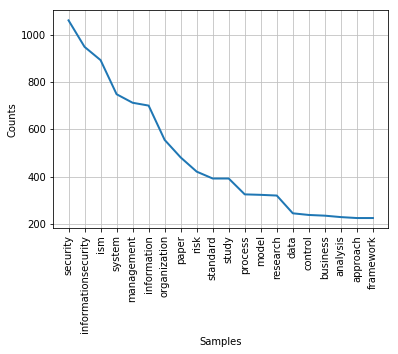

56130

In [41]:
freq.plot(20, cumulative=False)
len(li)

In [49]:
pd_source

,Key,Item Type,Publication Year,Author,Title,Publication Title,ISBN,ISSN,DOI,Url,...,Programming Language,Version,System,Code,Code Number,Section,Session,Committee,History,Legislative Body
0,X7YSC7CJ,conferencePaper,2009,"Abawajy, Jemal H","""Design and Delivery of Undergraduate Informat...",ADVANCES IN InformationSecurity AND ASSURANCE,978-3-642-02616-4,NaN,"""10.1007/978-3-642-02617-1_41""",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,THTF9GDG,conferencePaper,2008,"Kamel, M.; Laborde, R.; Benzekri, A.; Barrere, F.",A best practices-oriented approach for establi...,Proceedings - IEEE International Enterprise Di...,978-1-4244-4485-4,NaN,10.1109/EDOCW.2008.3,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,9EJF8UK5,conferencePaper,2017,"Fangfang, Dang; Fajia, Ji; Lei, Zhu; Ying, Yang",A Brief Talk on InformationSecurity Basic Man...,Proceedings of the 2017 4Th International Conf...,978-94-6252-439-2,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,W3BP36PA,conferencePaper,2011,"Sadok, M.; Spagnoletti, P.",A business aware InformationSecurity risk ana...,Information Technology and Innovation Trends i...,978-3-7908-2631-9,NaN,10.1007/978-3-7908-2632-6_51,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,H74DE578,journalArticle,2015,"Ahmad, Atif; Maynard, Sean B.; Shanks, Graeme",A case analysis of information systems and sec...,International Journal of Information Management,NaN,02684012,10.1016/j.ijinfomgt.2015.08.001,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,K7G7R46X,journalArticle,2018,"Abdul Molok, Nurul Nuha; Ahmad, Atif; Chang, S...",A case analysis of securing organisations agai...,International Journal of Information Management,NaN,02684012,10.1016/j.ijinfomgt.2018.08.013,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,GAEKDFWH,conferencePaper,2015,"Huang, Rengen; Zhu, Zhen",A Case Study on Risk Management of Enterprise ...,2015 2nd International Conference on Creative ...,978-981-09-4799-6,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,EBAN5CSK,conferencePaper,2016,"Sisiaridis, Dimitrios; Kuchta, Veronika; Marko...",A Categorical Approach in Handling Event-Order...,2016 Ieee 22Nd International Conference on Par...,978-1-5090-4457-3,NaN,10.1109/ICPADS.2016.148,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,FK9BNQXJ,conferencePaper,2011,"Wang, P; Xing, L N",A Collaborative Framework for ISM Using Inte...,"Components, Packaging and Manufacturing Techno...",1013-9826,NaN,10.4028/www.scientific.net/KEM.460-461.428,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,P3AEHBJM,conferencePaper,2010,"Karabacak, Bilge; Ozkan, Sevgi",A Collaborative Process Based Risk Analysis fo...,Proceedings of the 5Th International Conferenc...,978-1-906638-61-0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [50]:
def format_topics_sentences(ldamodel=result, corpus=doc_term_matrix, texts=None):
    
    sent_topics_df = pd.DataFrame()
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=result, corpus=doc_term_matrix, texts=pd_source['Key'])

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,3.0,0.9004,"system, management, security, information, ism...",X7YSC7CJ
1,1,3.0,0.9916,"system, management, security, information, ism...",THTF9GDG
2,2,3.0,0.9859,"system, management, security, information, ism...",9EJF8UK5
3,3,6.0,0.9130,"informationsecurity, management, standard, inf...",W3BP36PA
4,4,8.0,0.7128,"risk, process, organization, security, informa...",H74DE578
5,5,5.0,0.6607,"ism, security, informationsecurity, informatio...",K7G7R46X
6,6,5.0,0.5241,"ism, security, informationsecurity, informatio...",GAEKDFWH
7,7,1.0,0.9836,"ism, information, system, management, informat...",EBAN5CSK
8,8,1.0,0.9850,"ism, information, system, management, informat...",FK9BNQXJ
9,9,8.0,0.9904,"risk, process, organization, security, informa...",P3AEHBJM


In [91]:
df_dominant_topic['Topic_Perc_Contrib'].max()

0.9976999759674072

In [92]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.9940,"security, informationsecurity, process, ism, management, policy, paper, organization, control, i...",Y5P8LSB5
1,1.0,0.9955,"ism, information, system, management, informationsecurity, security, network, paper, organizatio...",45TJQGZ4
2,2.0,0.9953,"security, informationsecurity, ism, employee, research, organization, paper, model, study, culture",4YQ52CCA
3,3.0,0.9959,"system, management, security, information, ism, informationsecurity, organization, paper, servic...",U9BYYXEZ
4,4.0,0.9965,"informationsecurity, organization, security, ism, information, paper, research, data, model, bus...",54DBYAX4
5,5.0,0.9977,"ism, security, informationsecurity, information, system, management, standard, organization, ris...",4SZR6VW2
6,6.0,0.9960,"informationsecurity, management, standard, information, security, ism, system, organization, ris...",9856DYQU
7,7.0,0.9961,"security, informationsecurity, study, paper, information, risk, system, research, ism, management",6F7RLF7Q
8,8.0,0.9937,"risk, process, organization, security, informationsecurity, model, ism, analysis, assessment, sy...",Y234UQ7Z
9,9.0,0.9934,"security, paper, ism, enterprise, model, system, informationsecurity, information, organization,...",Z6UFXSLD


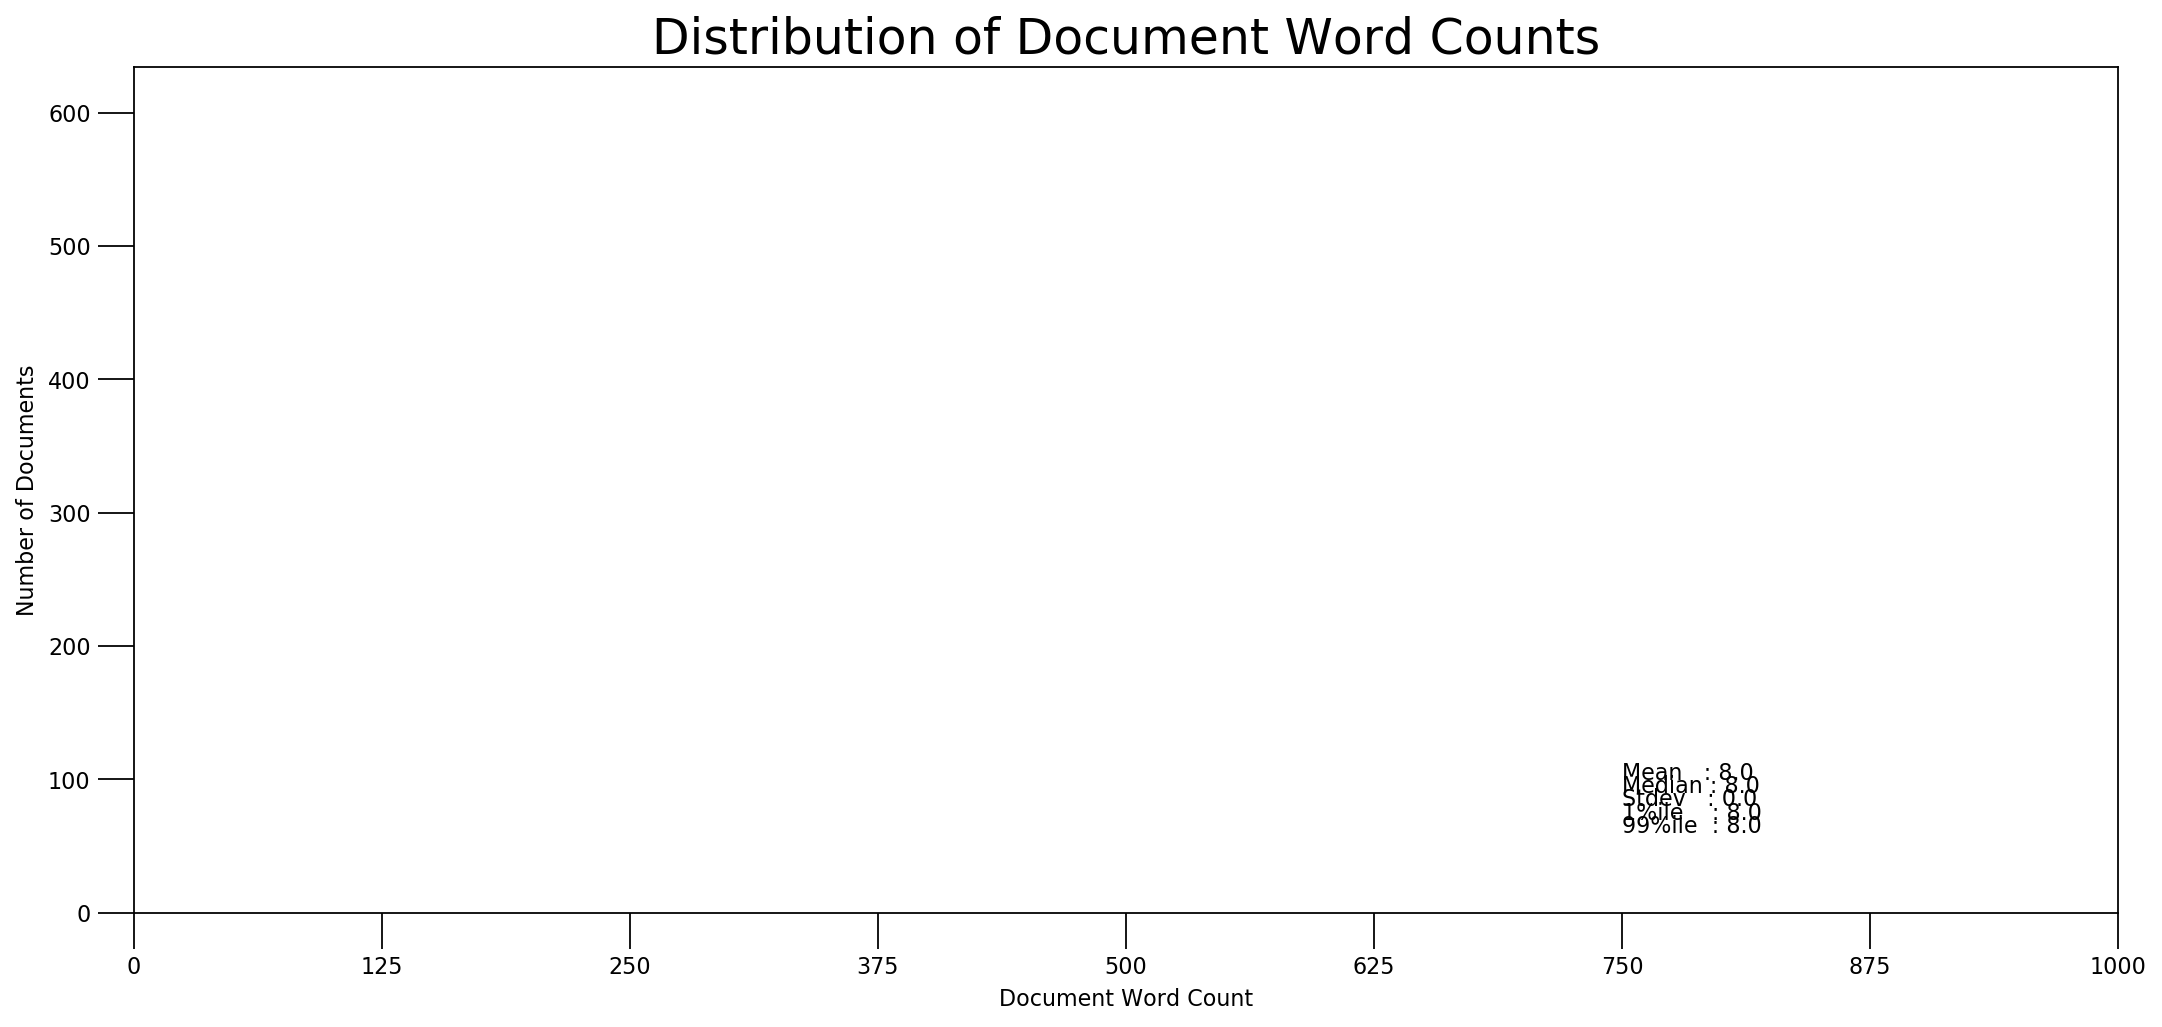

In [93]:
doc_lens = [len(d) for d in df_dominant_topic.Text]

# Plot
plt.figure(figsize=(16,7), dpi=160)
plt.hist(doc_lens, bins = 1000, color='navy')
plt.text(750, 100, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(750,  90, "Median : " + str(round(np.median(doc_lens))))
plt.text(750,  80, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(750,  70, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(750,  60, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 1000), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,1000,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.show()


LinAlgError: singular matrix

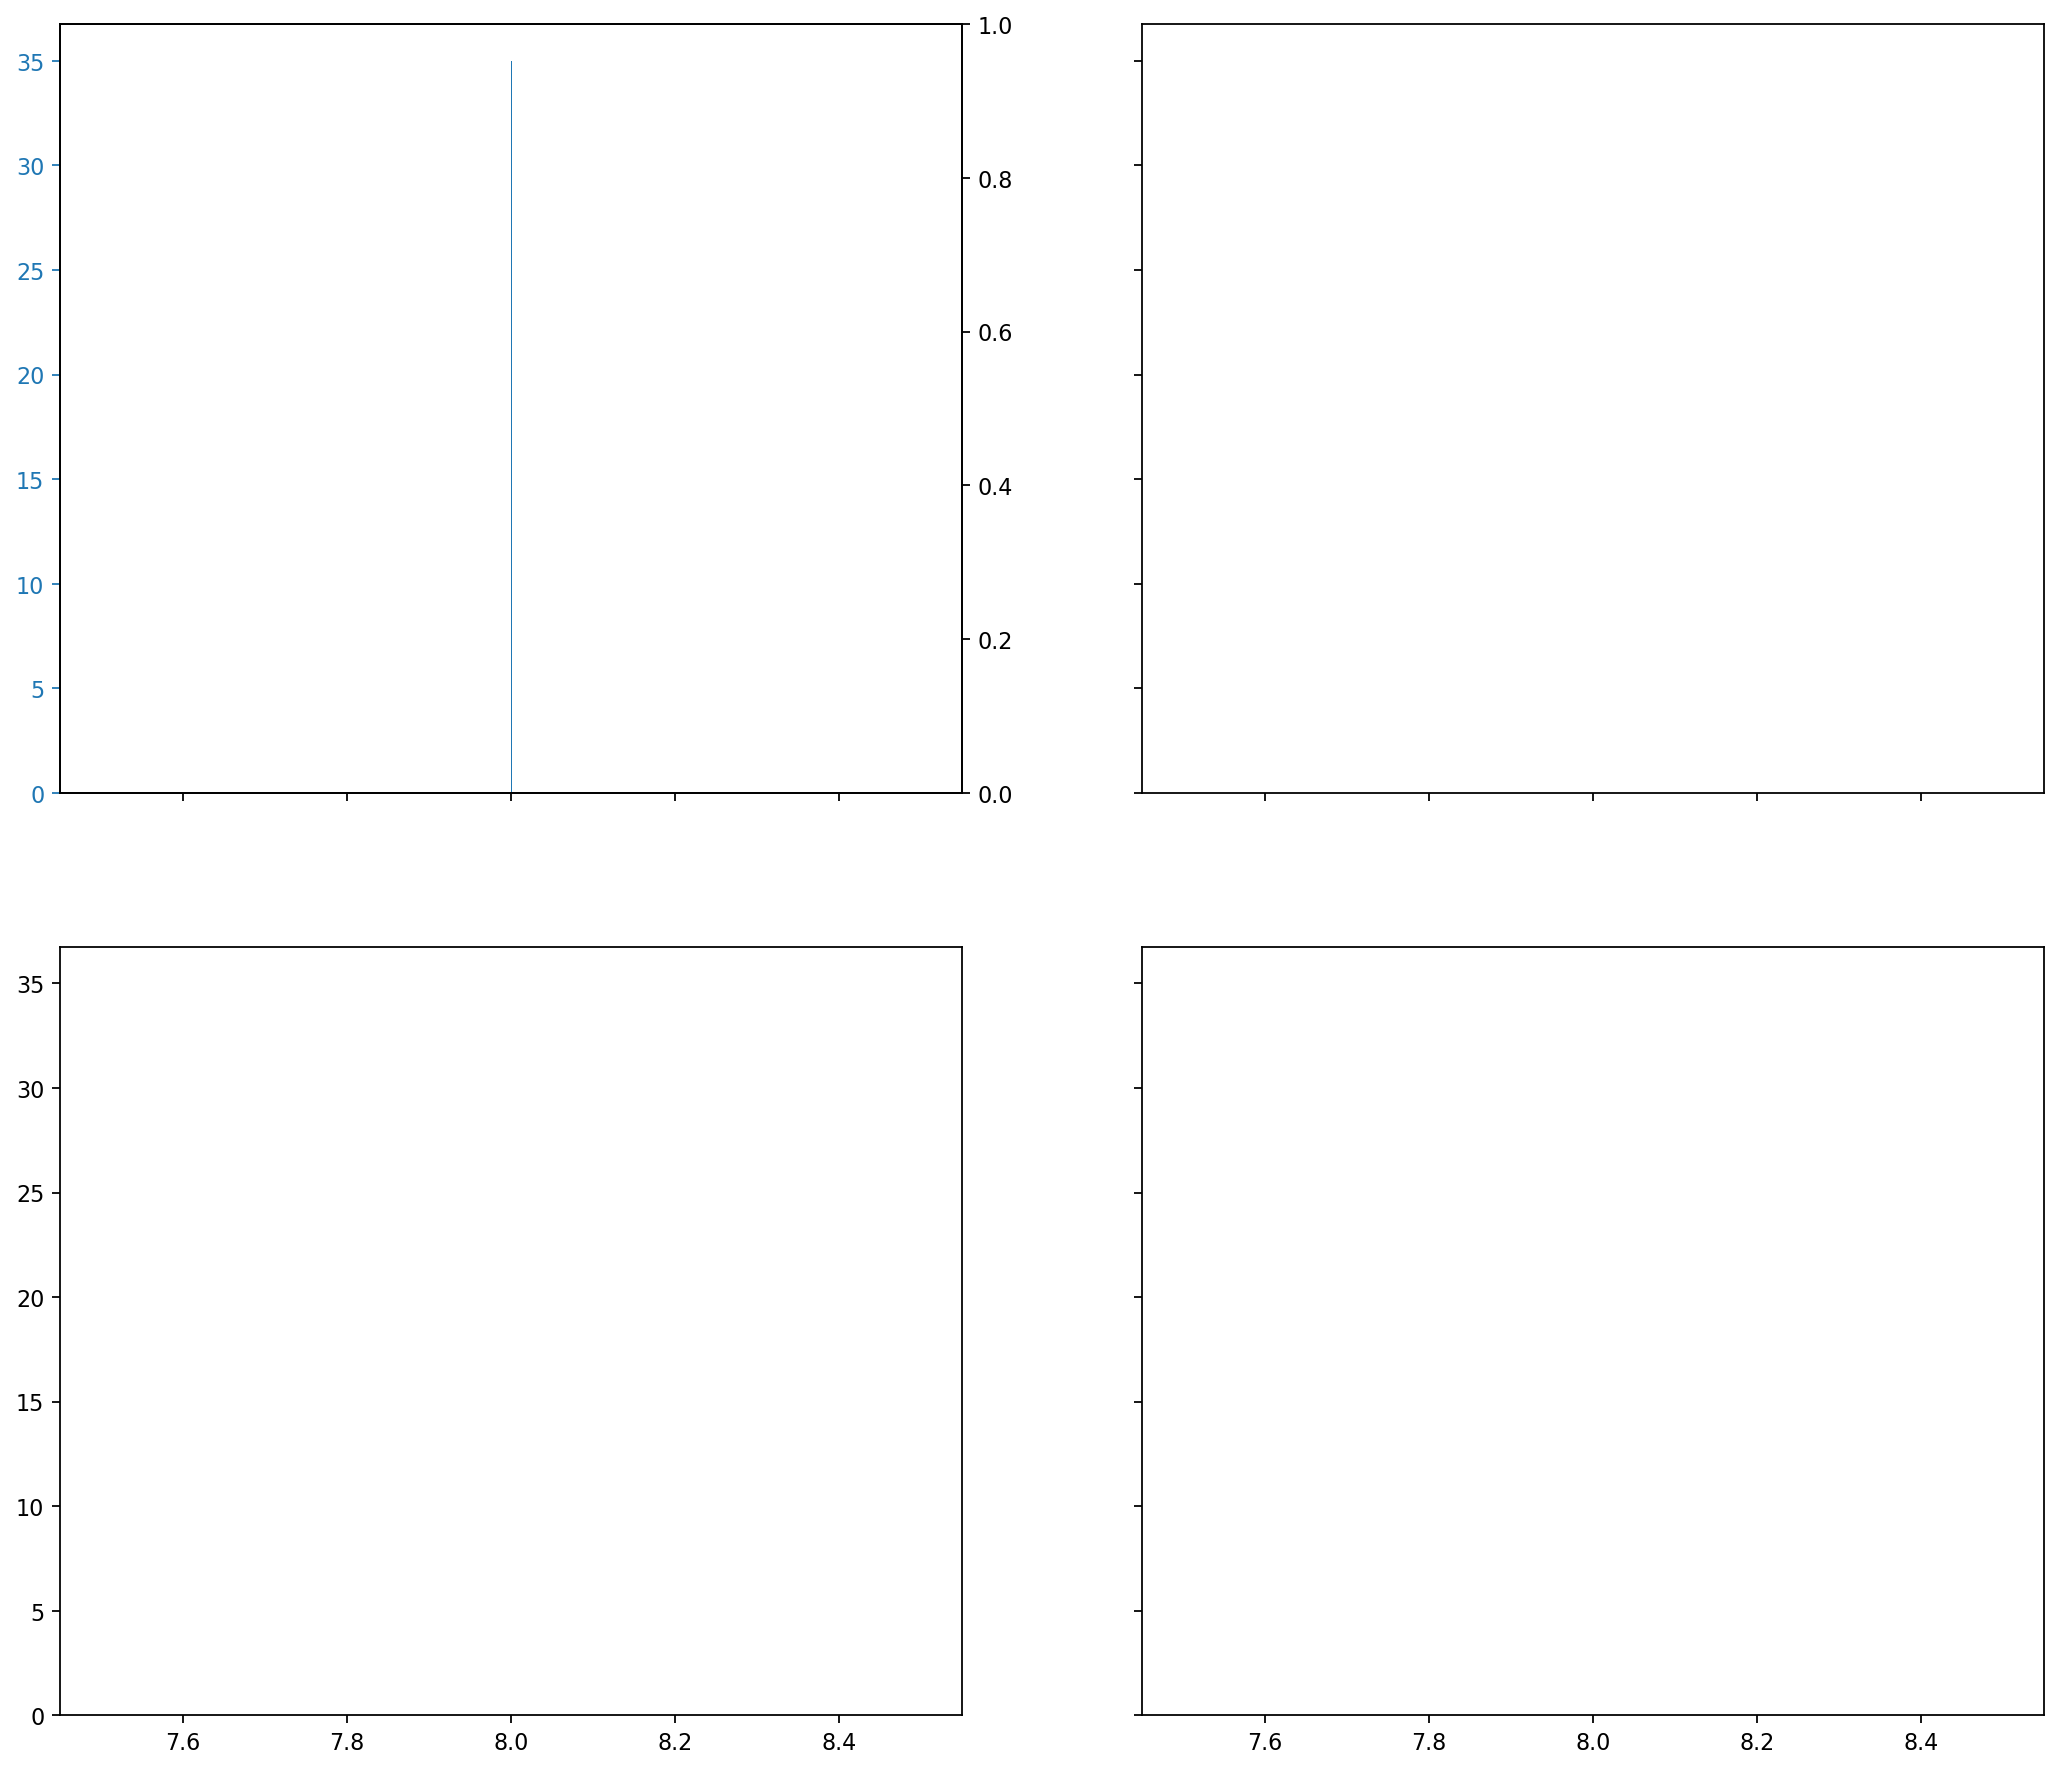

In [97]:
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(2,2,figsize=(16,14), dpi=160, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins = 1000, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 1000), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))
#compute_covariance
fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,1000,9))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()

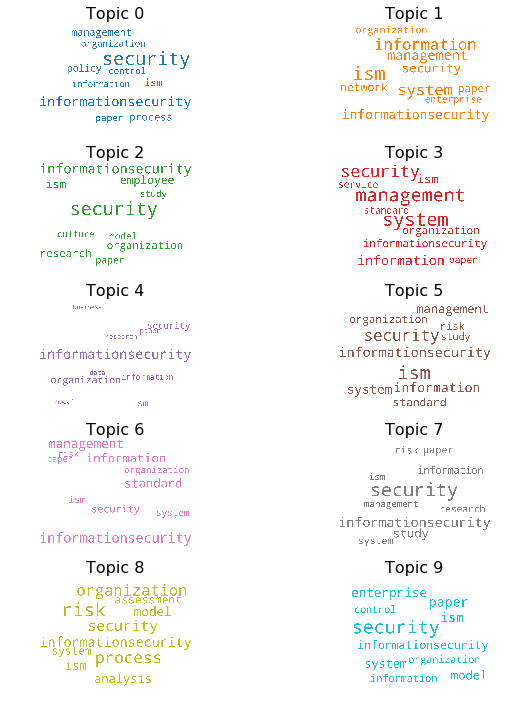

In [100]:
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = result.show_topics(formatted=False)

fig, axes = plt.subplots(5, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

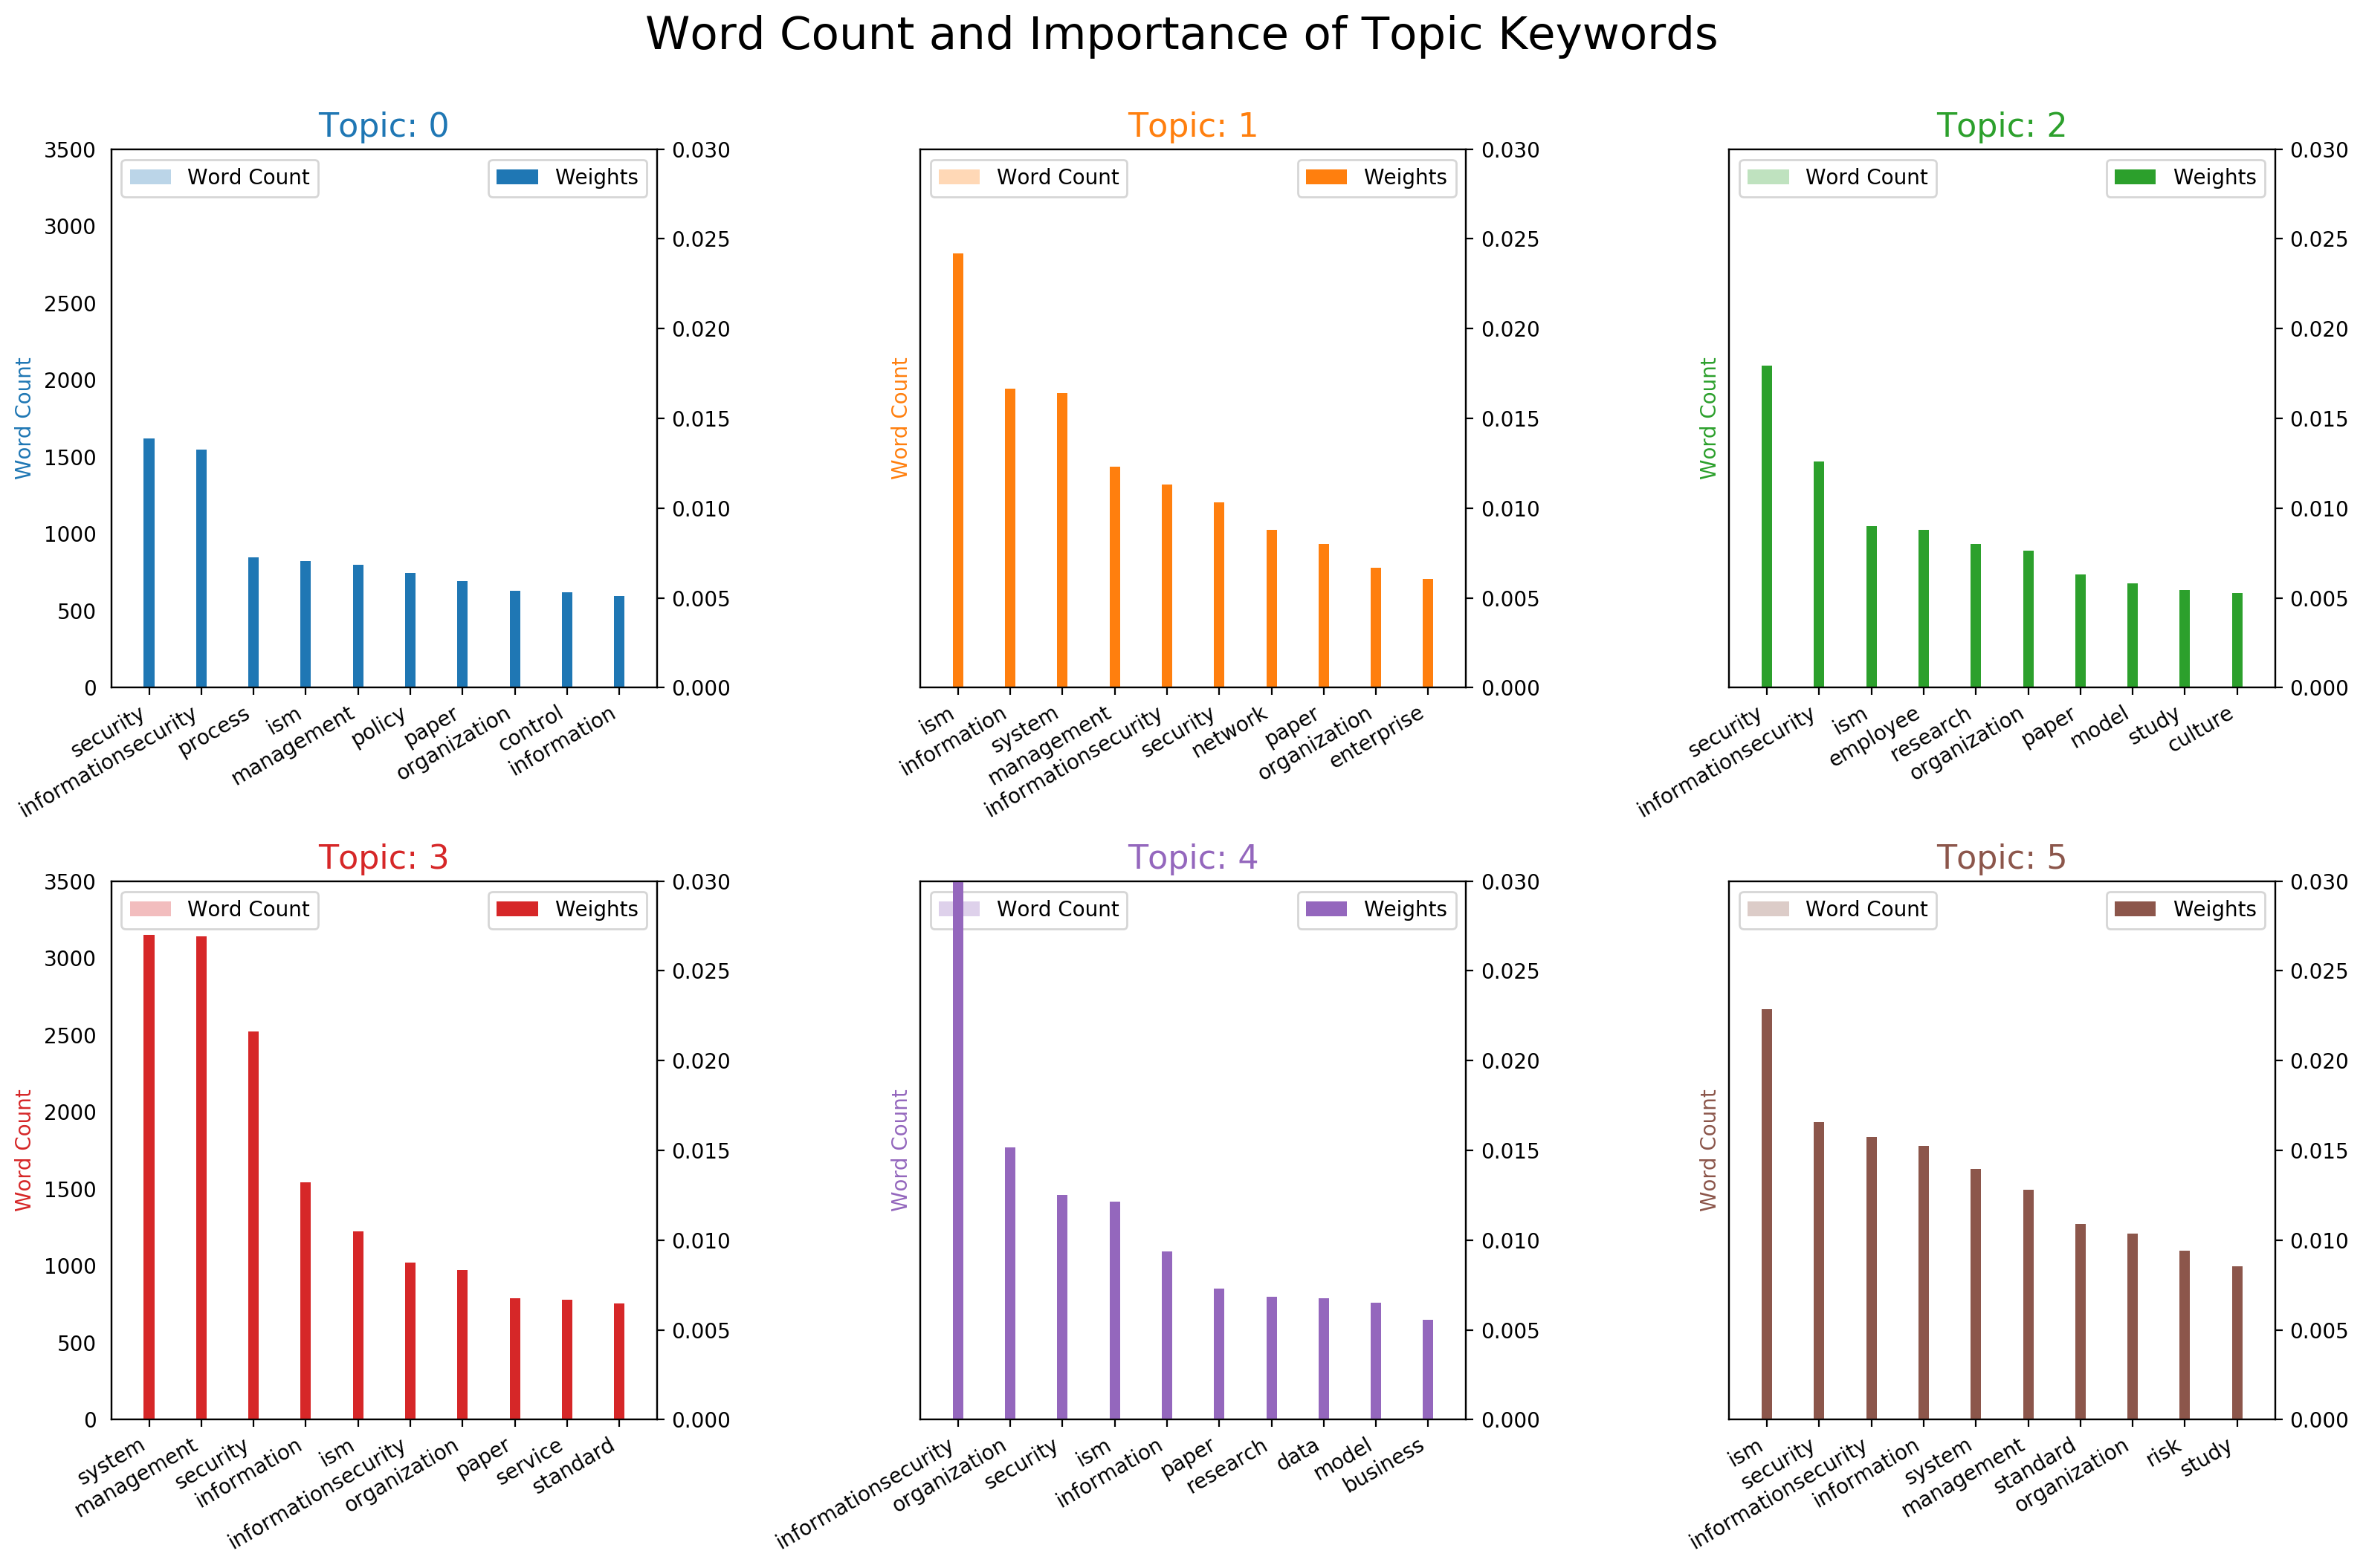

In [106]:
from collections import Counter
topics = result.show_topics(formatted=False)
data_flat = [w for w_list in data_ready for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 3, figsize=(16,10), sharey=True, dpi=200)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

TypeError: object of type 'int' has no len()

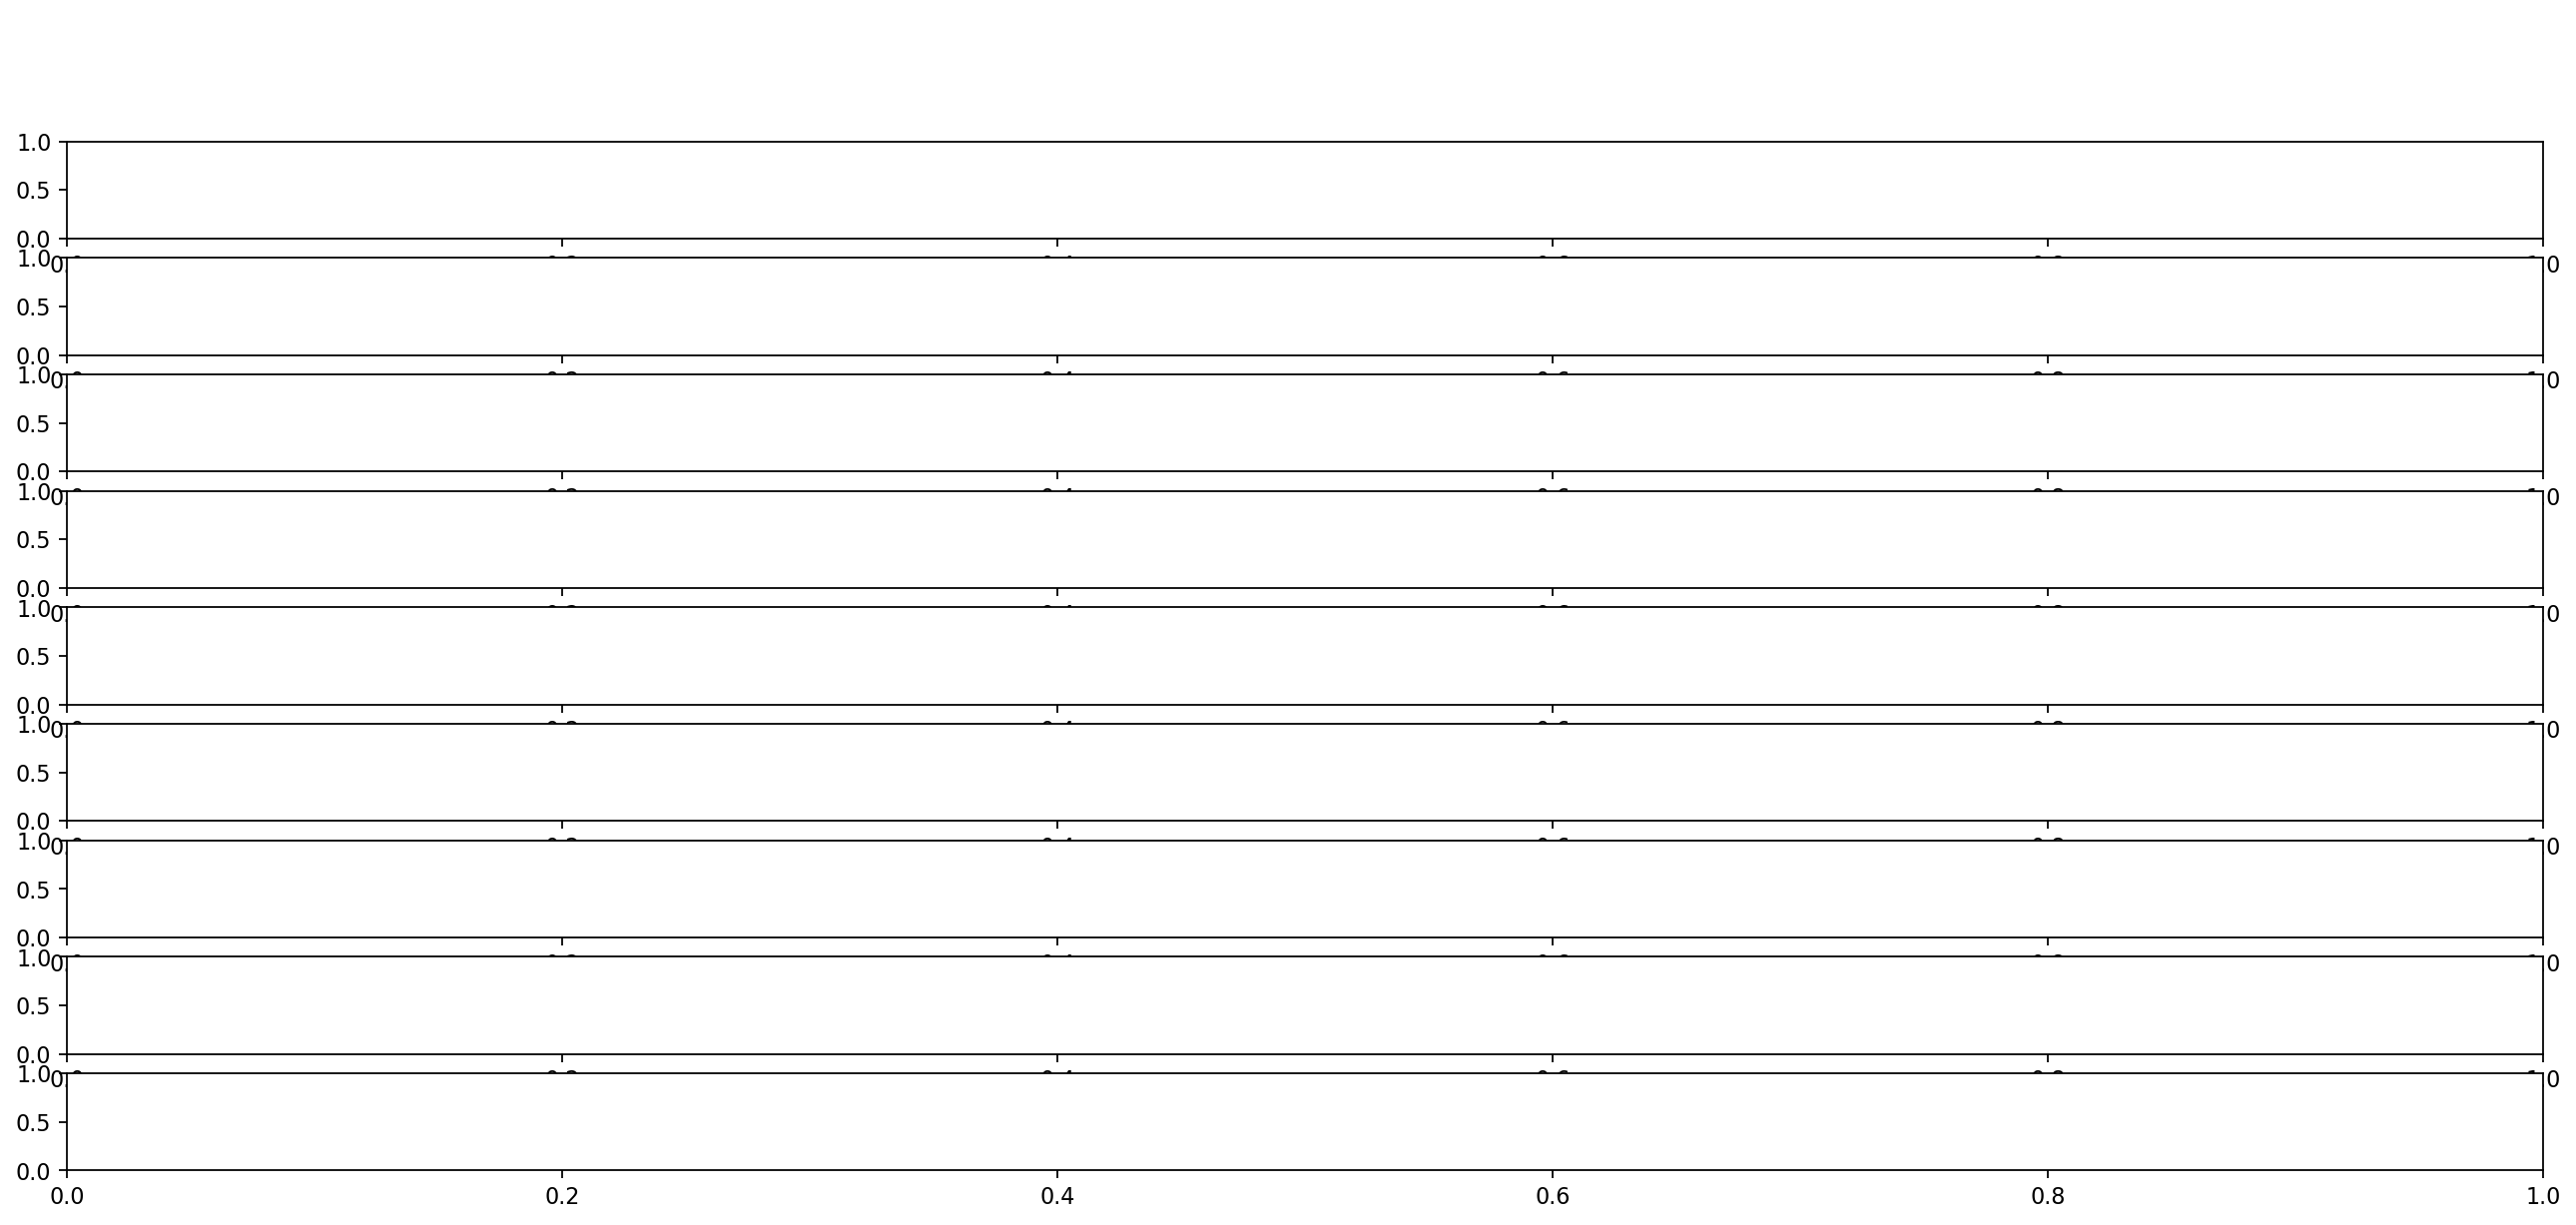

In [111]:
from matplotlib.patches import Rectangle

def sentences_chart(lda_model=result, corpus=doc_term_matrix, start = 0, end = 10):
    corp = corpus[start:end]
    mycolors = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    fig, axes = plt.subplots(end-start, 1, figsize=(20, (end-start)*0.95), dpi=160)       
    axes[0].axis('off')
    for i, ax in enumerate(axes):
        if i > 0:
            corp_cur = corp[i-1] 
            topic_percs, wordid_topics, wordid_phivalues = lda_model[corp_cur]
            word_dominanttopic = [(lda_model.id2word[wd], topic[0]) for wd, topic in wordid_topics]    
            ax.text(0.01, 0.5, "Doc " + str(i-1) + ": ", verticalalignment='center',
                    fontsize=16, color='black', transform=ax.transAxes, fontweight=700)

            # Draw Rectange
            topic_percs_sorted = sorted(topic_percs, key=lambda x: (x[1]), reverse=True)
            ax.add_patch(Rectangle((0.0, 0.05), 0.99, 0.90, fill=None, alpha=1, 
                                   color=mycolors[topic_percs_sorted[0][0]], linewidth=2))

            word_pos = 0.06
            for j, (word, topics) in enumerate(word_dominanttopic):
                if j < 14:
                    ax.text(word_pos, 0.5, word,
                            horizontalalignment='left',
                            verticalalignment='center',
                            fontsize=16, color=mycolors[topics],
                            transform=ax.transAxes, fontweight=700)
                    word_pos += .009 * len(word)  # to move the word for the next iter
                    ax.axis('off')
            ax.text(word_pos, 0.5, '. . .',
                    horizontalalignment='left',
                    verticalalignment='center',
                    fontsize=16, color='black',
                    transform=ax.transAxes)       

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle('Sentence Topic Coloring for Documents: ' + str(start) + ' to ' + str(end-2), fontsize=22, y=0.95, fontweight=700)
    plt.tight_layout()
    plt.show()

sentences_chart()    

In [116]:
# Sentence Coloring of N Sentences
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, wordid_topics, wordid_phivalues = model[1]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

dominant_topics, topic_percentages = topics_per_document(model=result, corpus=doc_term_matrix, end=-1)            

# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in lda_model.show_topics(formatted=False) 
                                 for j, (topic, wt) in enumerate(topics) if j < 3]

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
df_top3words.reset_index(level=0,inplace=True)

TypeError: object of type 'int' has no len()